## Investigating the processing step

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import timedelta

import datetime


from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR



2024-11-10 08:41:33.445 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
# set seed
np.random.seed(11)

In [3]:
figure_save_path = FIGURES_DIR / 'processing' / 'toy_examples'
figure_save_path.mkdir(parents=True, exist_ok=True)

### Creating example data

- iFix has data sampled at 1 minute intervals, but shifted
- whereas System2000 has irregularly sampled data
- and danova has regularly sampled data

In [4]:
def create_sine_wave(minutes=60, irregular=True):
    # create irregulare time series data 
    startdate='2019-01-01 00:00:00'
    # go x minutes into the future
    enddate = pd.Timestamp(startdate) + pd.Timedelta(minutes=minutes)
    # create a time index
    time_index = pd.date_range(startdate, enddate, freq='min')
    
    # create the sine wave
    half_idx = len(time_index) // 2
    half_time = time_index[half_idx]
    if irregular:
        # add some noise, seconds
        # first half shift all by 5 seconds
        time_index.values[1:half_idx-1] = time_index.values[1:half_idx-1] + pd.to_timedelta(5, unit='s')

        # for the second half, add random noise on -5 to 5 seconds
        time_index.values[half_idx+1:-1] = time_index.values[half_idx+1:-1] + pd.to_timedelta(np.random.randint(0, 7, len(time_index[half_idx+1:-1])), unit='s')
    # create a sine wave
    sine_wave = np.sin(np.linspace(0, 2*np.pi, len(time_index)))
    # create a dataframe
    df = pd.DataFrame({'time': time_index, 'value': sine_wave})
    # sort the dataframe
    df = df.sort_values('time')
    df.reset_index(drop=True, inplace=True)
    

    # create a copy of the value column without errors
    df['value_no_errors'] = df['value'].copy()


    # Create the iFIX data
    starttime = time_index[0]
    endtime = time_index[half_idx]
    # create a time index
    time_index_10s = pd.date_range(starttime, endtime, freq='10s')#[1:]
    df_10s = pd.DataFrame({'time': time_index_10s, 'value': np.nan})
    # remove those that are also in the original dataframe
    df_10s = df_10s.loc[~df_10s.time.isin(df.time)]
    
    # create the two scenarios of iFIX data; there the 10s are 0, and there the 10s are the real values
    zero_value_10s_sep = len(df_10s) // 4
    # zero
    df_10s.loc[:zero_value_10s_sep, ['value', 'value_no_errors']] = [0, np.nan]
    # set to nan and then interpolate:
    df_10s.loc[zero_value_10s_sep:, ['value', 'value_no_errors']] = [np.nan, np.nan]
    # concatenate the two dataframes
    df = pd.concat([df_10s, df])
    df.sort_values('time', inplace=True)
    # interpolate second half of 10s data
    start_half_10s = df_10s.loc[zero_value_10s_sep, 'time']
    df.loc[df.time >= start_half_10s, ['value', 'value_no_errors']] = df.loc[df.time >= start_half_10s, ['value', 'value_no_errors']].interpolate()
    # drop duplicates
    df.drop_duplicates(subset='time', inplace=True)
    # reset the index
    df.reset_index(drop=True, inplace=True)


    # The true series
    true_series = df.copy()
    error_mask = df['value'] != df['value_no_errors']
    true_series = true_series.loc[~error_mask]
    # drop the value_no_errors column
    true_series.drop('value_no_errors', axis=1, inplace=True)


    # Manipulate the data:

    # Data saving function
    start_minute = 11
    end_minute = 16
    # Extract the minute part of the time column and find rows to remove
    idx_saving = df[(df['time'].dt.minute >= start_minute) & (df['time'].dt.minute <= end_minute)].index
    # here the true series should just be constant
    #true_series.loc[min(idx_saving):max(idx_saving), 'value'] = df.loc[min(idx_saving), 'value']
    #true_series.drop(idx_saving, inplace=True)
    # set values to nan in true series
    true_series.loc[idx_saving, 'value'] = np.nan
    df.drop(idx_saving, inplace=True)
    # Make data in minute 17 erroneous
    start_minute = 17
    end_minute = 18
    # Extract the minute part of the time column and find rows to remove
    idx_err = df[(df['time'].dt.minute >= start_minute) & (df['time'].dt.minute <= end_minute)].index
    # set values to nan
    df.loc[idx_err, 'value_no_errors'] = np.nan  

    # Data saving function
    start_minute = 21
    end_minute = 25
    # Extract the minute part of the time column and find rows to remove
    idx_frozen_err = df[(df['time'].dt.minute >= start_minute) & (df['time'].dt.minute <= end_minute)].index
    # set values to nan in true series
    true_series.loc[idx_frozen_err, 'value'] = np.nan
    # Remove both
    df.drop(idx_frozen_err, inplace=True)
    #df.reset_index(drop=True, inplace=True)


    # # and remove 3 values within a minute
    # start_minute = 9
    # end_minute = 10
    # # Extract the minute part of the time column and find rows to remove
    # idx_remove = df[(df['time'].dt.minute >= start_minute) & (df['time'].dt.minute <= end_minute)].index
    # #idx_remove = idx_remove[1:4]
    # # the true series just keeps thesse values
    # # Remove the selected rows
    # df.drop(idx_remove, inplace=True)
    # #df.reset_index(drop=True, inplace=True)


    # Remove 3 values within a minute
    start_minute = 44
    end_minute = 47
    # Extract the minute part of the time column and find rows to remove
    idx_remove = df[(df['time'].dt.minute >= start_minute) & (df['time'].dt.minute <= end_minute)].index
    # the true series just keeps thesse values
    # Remove the selected rows
    df.drop(idx_remove, inplace=True)
    # set to nan for true series
    true_series.loc[idx_remove, 'value'] = np.nan
    #df.reset_index(drop=True, inplace=True)

    
    # add errors on minute _
    minute = 28
    minute_idx = df.loc[df.time.dt.minute == minute].index[0:4]
    df.loc[minute_idx,['value', 'value_no_errors']] = [0.5, np.nan]
    minute = 36
    minute_idx = df.loc[df.time.dt.minute == minute].index#[0]
    df.loc[minute_idx, ['value', 'value_no_errors']] = [0, np.nan]
    # no change to the true series


    # add 'true' spike on minutes 55
    minute = 55
    minute_idx = df.loc[df.time.dt.minute == minute].index#[0]
    df.loc[minute_idx, ['value', 'value_no_errors']] = [0.3, 0.3]
    # change the true series
    true_series.loc[minute_idx, 'value'] = 0.3


    #df.reset_index(drop=True, inplace=True)
    # errors are just when the two columns are not equal
    error_mask = df['value'] != df['value_no_errors']
    df['error'] = error_mask

    df.reset_index(drop=True, inplace=True)
    true_series.reset_index(drop=True, inplace=True)

    # split the data into two sets for iFix and System2000 based on the half_idx
    sep_12_index = df.loc[df.time == endtime].index[0]
    ifix = df.loc[df.index <= sep_12_index].copy()
    ifix.reset_index(inplace=True, drop=True)
    system2000 = df.loc[df.index >= sep_12_index].copy()
    system2000.reset_index(inplace=True, drop=True)


    # Danova data
    startdate = df.time.max().replace(second=0, microsecond=0)
    enddate = startdate + pd.Timedelta(minutes=30)
    time_index = pd.date_range(startdate, enddate, freq='2min') # the 2 minute frequency
    # create a sine wave
    sine_wave = np.sin(np.linspace(0, 2*np.pi, len(time_index)))
    # create a dataframe
    danova = pd.DataFrame({'time': time_index, 'value': sine_wave, 'value_no_errors': sine_wave, 'error': False, 'ffill': False})
    true_danova = danova.copy()   
    # set the last 8 values to nan, except the very last
    danova.drop(range(len(danova)-7, len(danova)-2), inplace=True)
    # set the second to last value to nan
    danova.loc[danova.index[-2], ['value_no_errors', 'error']] = [np.nan, True]

    true_danova.loc[len(true_danova)-7:len(true_danova)-2, 'value'] = np.nan
    danova.reset_index(drop=True, inplace=True)

    # drop the last of the df and system2000
    df.drop(df.index[-1], inplace=True); system2000.drop(system2000.index[-1], inplace=True)
    
    # concatenate the two dataframes
    df = pd.concat([df, danova])
    true_series = pd.concat([true_series, true_danova[['time', 'value']]])

    # reset the index
    df.reset_index(drop=True, inplace=True)
    true_series.reset_index(drop=True, inplace=True)    
    sep_23_idx = df.loc[df.time == startdate].index[0]


    return true_series, df, ifix, system2000, danova, sep_12_index, sep_23_idx
    

In [5]:
true_series, data, ifix, system2000, danova, sep_12_index, sep_23_idx = create_sine_wave(minutes=60)
error_mask = data['value'] != data['value_no_errors']
errors = data.loc[error_mask].copy()

In [6]:
def default_data_plot(sep_12_index, sep_23_idx):
    # add vertical lines for the removed data
    plt.axvline(data.time[sep_12_index], color='grey', linestyle='--')
    plt.axvline(data.time[sep_23_idx], color='grey', linestyle='--')

    # apply coloring based on the half_idx
    plt.axvspan(data.time.min() - pd.Timedelta(minutes=1), data.time[sep_12_index], color='olivedrab', alpha=0.15)
    plt.axvspan(data.time[sep_12_index], data.time[sep_23_idx], color='teal', alpha=0.15)
    plt.axvspan(data.time[sep_23_idx], data.time.max() + pd.Timedelta(minutes=1), color='black', alpha=0.15)

    # add text
    plt.text(data.time[sep_12_index] - pd.Timedelta(minutes=17), 2.3, 'iFIX', color='olivedrab', fontsize=16, fontweight='bold')
    plt.text(data.time[sep_12_index] + pd.Timedelta(minutes=10), 2.3, 'System2000', color='teal', fontsize=16, fontweight='bold')
    plt.text(data.time[sep_23_idx] + pd.Timedelta(minutes=13), 2.3, 'Danova', color='black', fontsize=16, fontweight='bold')
    

    plt.xlabel('Time')
    plt.ylabel('Sine wave')
    # set xlim
    plt.xlim(data.time.min() - pd.Timedelta(minutes=1), data.time.max() + pd.Timedelta(minutes=1))
    # set ylim to -1.2 to 2.2
    plt.ylim(-1.2, 2.2)
    #plt.title('Time series data with errors')
    # Set x-ticks every 5 minutes, starting at minute 0
    xlocator = mdates.MinuteLocator(byminute=list(range(0, 60, 5)), interval = 1)
    #[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,], interval = 1)
    plt.gca().xaxis.set_major_locator(xlocator)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.xticks(rotation=0)
    plt.grid()


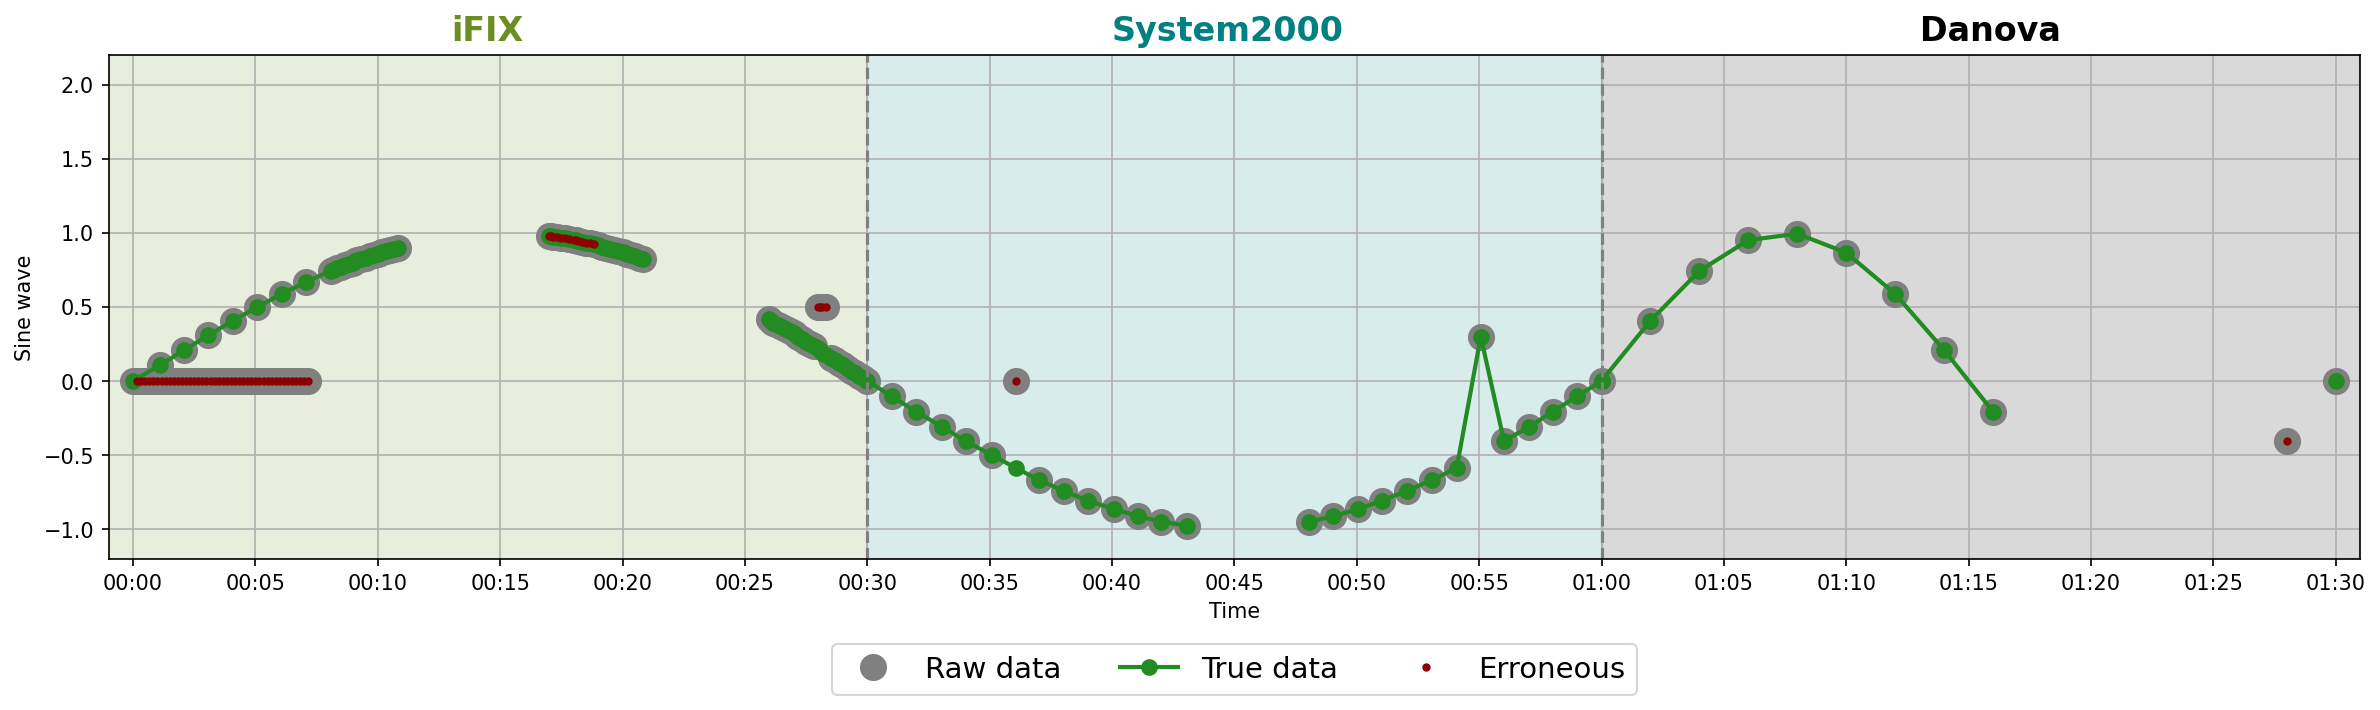

In [7]:

# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(data['time'], data['value'], 'o', color='gray', markersize=12)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)
#plt.plot(data.time, data['value_no_errors'], 'o', color='lightcoral', markersize=3.5)
errors = data.loc[data['error']]
plt.plot(errors['time'], errors['value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

# add legend
plt.legend(['Raw data','True data', 'Erroneous'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)
plt.tight_layout()
# save the plot
plt.savefig(figure_save_path / 'original_time_series.png')

plt.show()

### Simulating the data processing

- i.e. the make continuous series

In [8]:
# Provided

def Fill_data_savings_points(df, time='time', Timeperiod = '1min'): #df is a dataframe, time is name of time column, Timeperiod is min time period
    """Goal: Fill in missing time periods in the dataframe if the time period is larger than 1 minute, using forward fill."""
    df['ffill'] = pd.Series(np.zeros(len(df)),dtype=bool)    
    df[time] = pd.to_datetime(df[time])
    #new_df = df.set_index(time, drop=True)
    new_df = pd.DataFrame()
    # going through every consecutive pair of time points and checking if the difference is larger than 1 minute
    for i in range(0,(len(df[time])-1)):
        # if the difference is larger than 1 minute
        if df[time][i+1]-df[time][i] > pd.Timedelta(minutes=1):
            start = (df[time][i]+pd.Timedelta(minutes=1))
            # calculate the number of periods between the two time points, on a minute basis
            periods = (df[time][i+1]-df[time][i])/pd.Timedelta(minutes =1)
            
            # if the number of periods is larger than 1, we need to fill in the missing time points
            if periods%1>0: #Find the modulus of periods
                b = pd.date_range(start = start, periods = periods, freq = Timeperiod )
            else: #Ensure that there will not be identical timeperiods if the modulus is 1
                b = pd.date_range(start = start, periods = (periods-1), freq = Timeperiod ) 
            
            b = pd.DataFrame(data=b)
            b['ffill'] = True
            # add the new time points to the dataframe
            new_df = pd.concat([new_df, b], axis=0)
            
    new_df.columns = [time, 'ffill']
    # concat and sort the dataframes
    output = pd.concat([df, new_df], axis=0)
    output.sort_values(by=[time], inplace=True)
    output = output.reset_index(drop=True)
   
    return output


def NoFill_data_savings_points(df, time='time', Timeperiod = '1min'): #df is a dataframe, time is name of time column, Timeperiod is min time period
    flag_pad = pd.Series(np.zeros(len(df.value)),dtype=bool)    
    output = pd.DataFrame({'time': df['time'],
                         'value': df['value'],
                         'value_no_errors': df['value_no_errors'],
                            'error': df['error'],
                         'ffill': flag_pad})
    
    return output


In [9]:
ifix = Fill_data_savings_points(ifix.copy())
# in case of na where there are errors, fill with False
ifix['error'] = ifix['error'].fillna(False)
system2000 = NoFill_data_savings_points(system2000.copy())
danova = NoFill_data_savings_points(danova.copy())


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/3329528129.py:19: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  b = pd.date_range(start = start, periods = periods, freq = Timeperiod )
/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/3329528129.py:19: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  b = pd.date_range(start = start, periods = periods, freq = Timeperiod )
/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/1856418997.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ifix['er

In [10]:
# rename value to raw_value
ifix.rename(columns={'value': 'raw_value'}, inplace=True)
system2000.rename(columns={'value': 'raw_value'}, inplace=True)
danova.rename(columns={'value': 'raw_value'}, inplace=True)

In [11]:
# Provided

def make_continous_series(raw_data, start, end):
    #drop if nan value present
    #raw_data=raw_data.dropna(subset = ['value_no_errors'])
    
    #Group to mean values in 1 minute scale
    timeseries = raw_data.set_index('time').resample('1min').mean() 
    #To explore statistics
    #ts_meanminmax = raw_data.set_index('time').resample('T').agg({'value_no_errors': ['mean', 'min', 'max'], 'outbound':['min','max']}) 
    
    #ensures that there is true-false values in flags. If value present in "value_no_errors" then true-false value should be false. 
    lcolumn = [col for col in list(timeseries.columns) if col not in ['raw_value', 'value_no_errors']]
    for col in lcolumn: 
        timeseries[col] = timeseries[col].where(timeseries[col]==1, 0)
        timeseries[col] = timeseries[col].astype(bool)
   
    #Forward-fill for datapoints that needs to be forward-filled, and interpolate with rest. 
    temp = pd.Series(timeseries['value_no_errors'])
    temp_pad = temp.interpolate(method='pad') # by pad method, forward fill is done
    temp2 = temp.copy() 
    temp2.loc[timeseries['ffill'] == True] = temp_pad # replace the values that need to be forward-filled
           
    temp3 = temp2.interpolate(method='linear', limit = 5)
    
    timeseries_interpolated = pd.DataFrame(temp3)
    timeseries_interpolated.columns = ['depth_s']    
    result = pd.concat([timeseries, timeseries_interpolated], axis=1, sort=False)
    result.reset_index(inplace = True)    
        
    # NOTE: only the interpolated has performed forward fill, the other columns have not been forward filled based on the iFix indicator

    #Make continous timeseries with values and use only valid dates
    date_start = pd.to_datetime(start, format = "%d-%m-%Y")
    date_end = pd.to_datetime(end, format = "%d-%m-%Y")
        
    data_lim = result[(result['time'] >= date_start) & (result['time'] <= date_end)]
    #data_lim = result.copy() #JUST FOR TESTING
  
    return data_lim#, ts_meanminmax


In [12]:
# round to full minutes
starttime = ifix['time'].min().replace(second=0, microsecond=0)
endtime = ifix['time'].max().replace(second=0, microsecond=0)
ts_ifix = make_continous_series(ifix, starttime, endtime)

starttime = system2000['time'].min().replace(second=0, microsecond=0)
endtime = system2000['time'].max().replace(second=0, microsecond=0)
ts_system2000 = make_continous_series(system2000, starttime, endtime)

starttime = danova['time'].min().replace(second=0, microsecond=0)
endtime = danova['time'].max().replace(second=0, microsecond=0)
ts_danova = make_continous_series(danova, starttime, endtime)


/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/366761930.py:20: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_pad = temp.interpolate(method='pad') # by pad method, forward fill is done
/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/366761930.py:20: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_pad = temp.interpolate(method='pad') # by pad method, forward fill is done
/var/folders/p0/2qnwrmjn7yd0ks7pnlb3d7mc0000gn/T/ipykernel_68901/366761930.py:20: FutureWarning: Series.interpolate with method=pad is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_pad = temp.interpolate(method='pad') # by pad method, forward fill is done


In [13]:

complete_data = pd.concat([ts_ifix, ts_system2000, ts_danova])


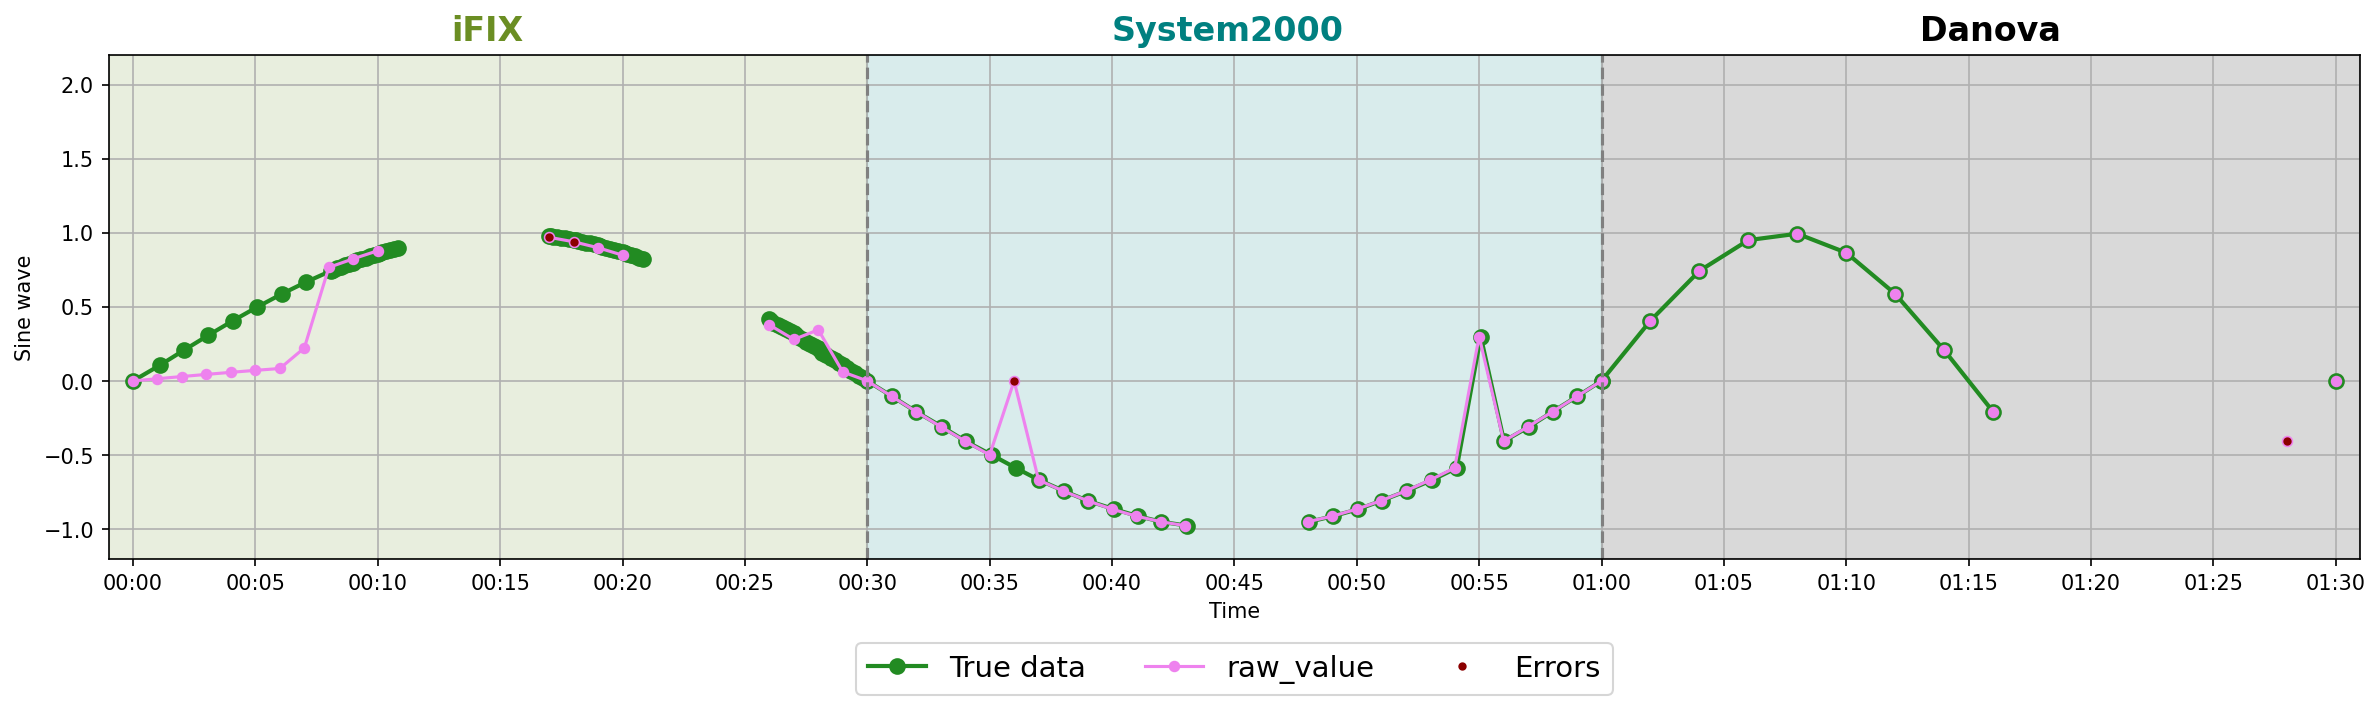

In [14]:
# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)

plt.plot(complete_data['time'], complete_data['raw_value'], 'o-', color='violet', markersize=4.5)

errors = complete_data.loc[complete_data['error']]
plt.plot(errors['time'], errors['raw_value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

plt.legend(['True data', 'raw_value', 'Errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)

plt.tight_layout()
# save the plot
plt.savefig(figure_save_path / 'provided_raw_value.png')

plt.show()

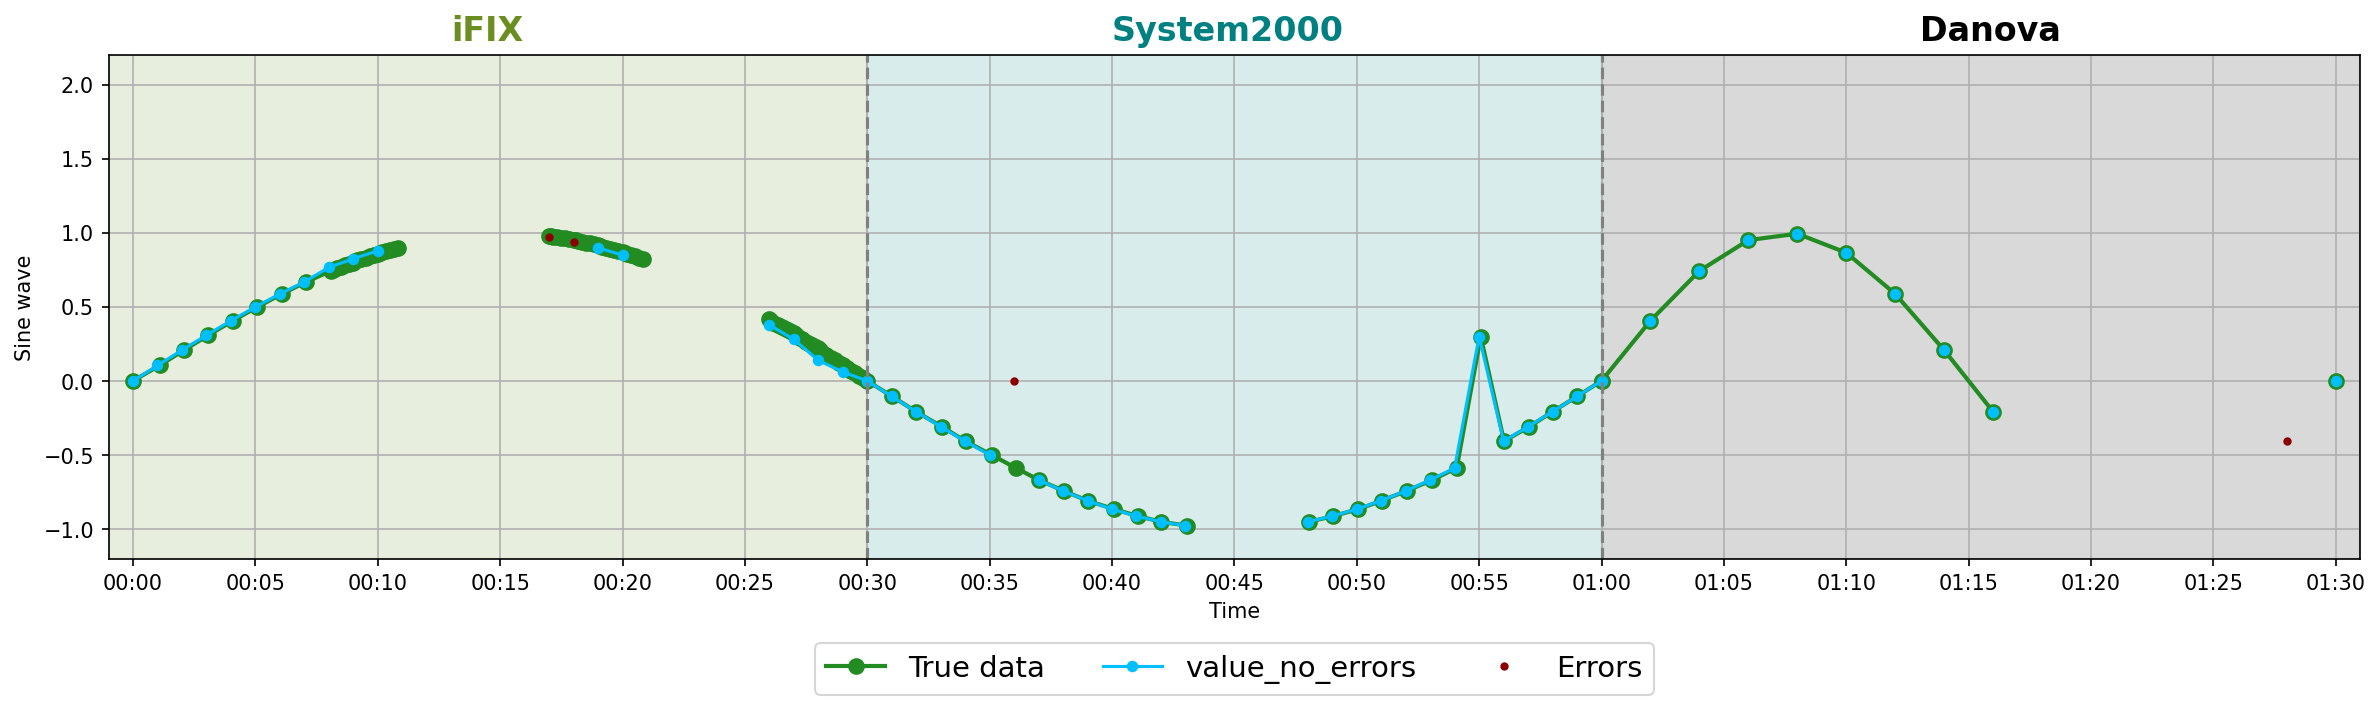

In [15]:
# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)

plt.plot(complete_data['time'], complete_data['value_no_errors'], 'o-', color='deepskyblue', markersize=4.5)

errors = complete_data.loc[complete_data['error']]
plt.plot(errors['time'], errors['raw_value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

plt.legend(['True data', 'value_no_errors', 'Errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)


plt.tight_layout()
plt.savefig(figure_save_path / 'provided_value_no_errors.png')
plt.show()

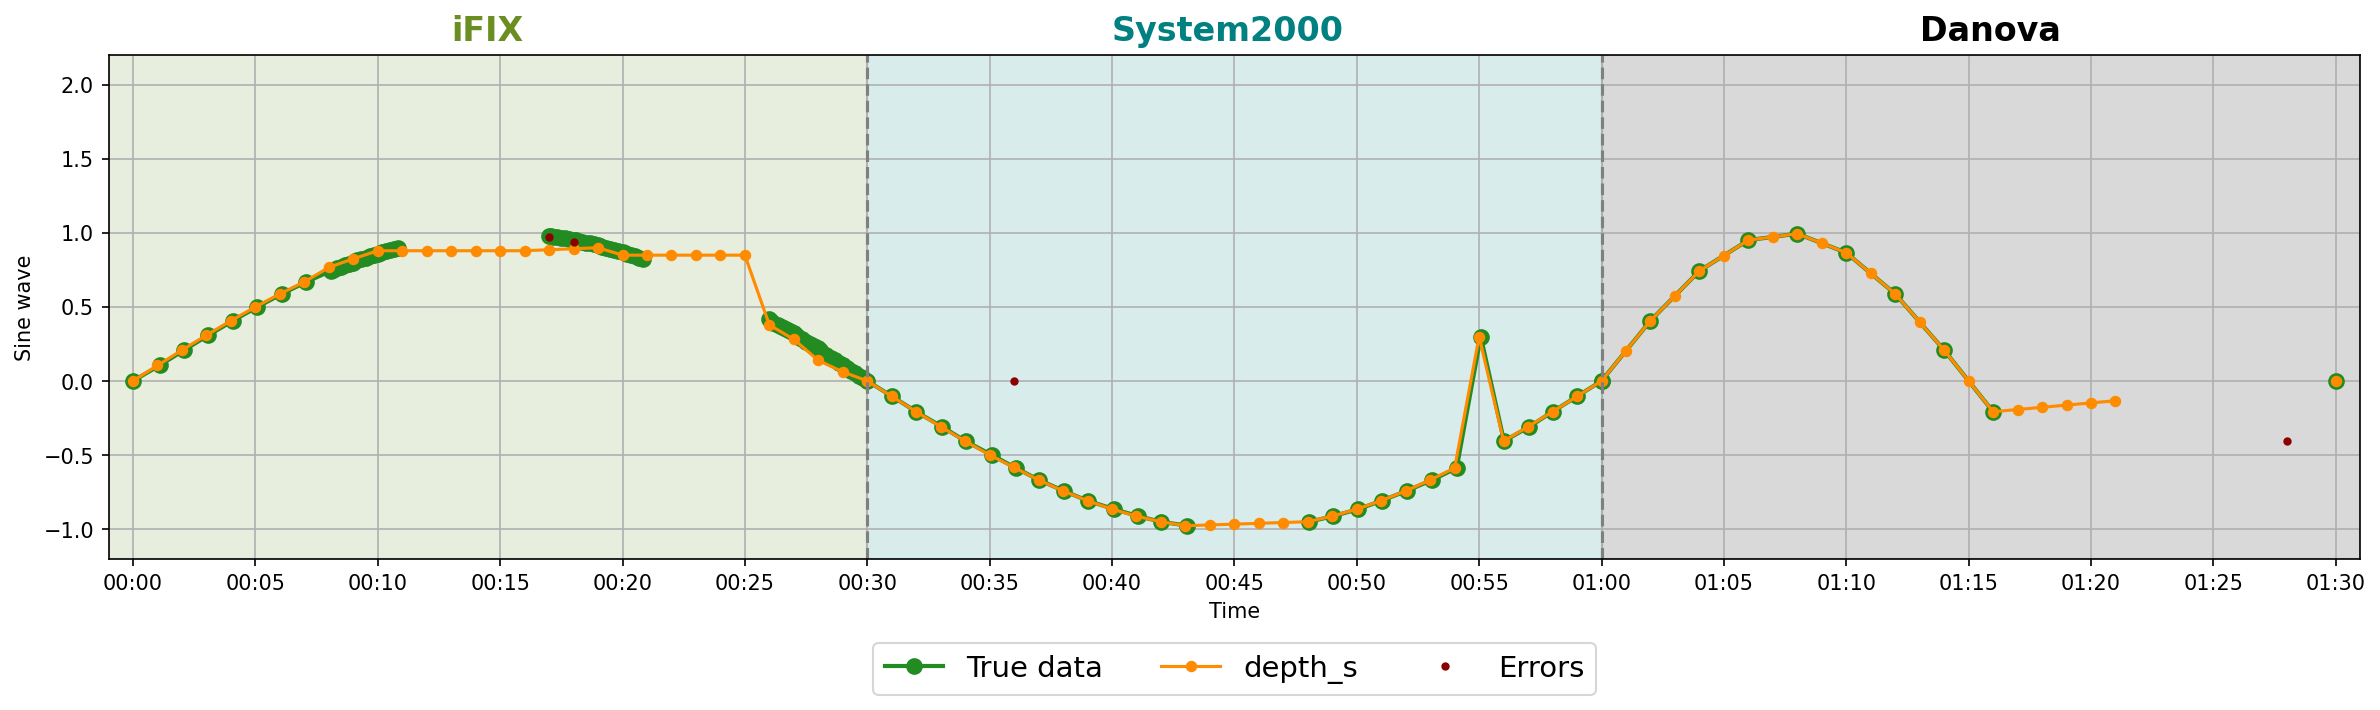

In [16]:
# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)

plt.plot(complete_data['time'], complete_data['depth_s'], 'o-', color='darkorange', markersize=4.5)

errors = complete_data.loc[complete_data['error']]
plt.plot(errors['time'], errors['raw_value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

plt.legend(['True data', 'depth_s', 'Errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)


plt.tight_layout()
plt.savefig(figure_save_path / 'provided_depth_s.png')
plt.show()


# Adjusted processing

goal
- use as much as possible from the previous
- improve the mentioned issues

- it will only be the `make_continous_series` function that will be improved

In [17]:
# # import all the necessary functions from the provided script
# from fault_management_uds.data.process import process_data

# # Provided functions (some fixed)
# from fault_management_uds.data.bellinge import ifix_forward_fill
# from fault_management_uds.data.bellinge import import_system2000, import_ifix, import_danova
from fault_management_uds.data.bellinge import Fill_data_savings_points, NoFill_data_savings_points, handle_ifix_data_saving
# from fault_management_uds.data.bellinge import Stamped_error, Remove_man, Out_of_bounds, Frozen_sensor, Outlier_point

from fault_management_uds.data.process import process_with_adjusted

In [18]:
true_series, data, ifix, system2000, danova, sep_12_index, sep_23_idx = create_sine_wave(minutes=60)
error_mask = data['value'] != data['value_no_errors']
errors = data.loc[error_mask].copy()

In [19]:
ifix = Fill_data_savings_points(ifix.copy(), col="value")
# in case of na where there are errors, fill with False
temp_save = system2000[['value_no_errors', 'error']]
system2000 = NoFill_data_savings_points(system2000.copy())
system2000[['value_no_errors', 'error']] = temp_save
temp_save = danova[['value_no_errors', 'error']]
danova = NoFill_data_savings_points(danova.copy())
danova[['value_no_errors', 'error']] = temp_save

# rename value to raw_value
ifix.rename(columns={'value': 'raw_value'}, inplace=True)
system2000.rename(columns={'value': 'raw_value'}, inplace=True)
danova.rename(columns={'value': 'raw_value'}, inplace=True)

In [20]:
ifix['ffill'].sum()

11

In [21]:
bool_columns = ['ffill', 'error']
error_indicators = ['error']

# round to full minutes
print('ifix')
# ifix = handle_ifix_data_saving(ifix, error_indicators)
window_frozen = 20

starttime = ifix['time'].min().replace(second=0, microsecond=0)
endtime = ifix['time'].max().replace(second=0, microsecond=0)
ts_ifix = process_with_adjusted(ifix, starttime, endtime, error_indicators, {"Source": "iFix", "window_frozen": window_frozen})


print('system2000') 
starttime = system2000['time'].min().replace(second=0, microsecond=0)
endtime = system2000['time'].max().replace(second=0, microsecond=0)
ts_system2000 = process_with_adjusted(system2000, starttime, endtime, error_indicators, {"Source": "System2000", "window_frozen": window_frozen})

print('danova')
starttime = danova['time'].min().replace(second=0, microsecond=0)
endtime = danova['time'].max().replace(second=0, microsecond=0)
ts_danova = process_with_adjusted(danova, starttime, endtime, error_indicators, {"Source": "Danova", "window_frozen": window_frozen})

ifix
system2000
danova


In [22]:
complete_data = pd.concat([ts_ifix, ts_system2000, ts_danova])

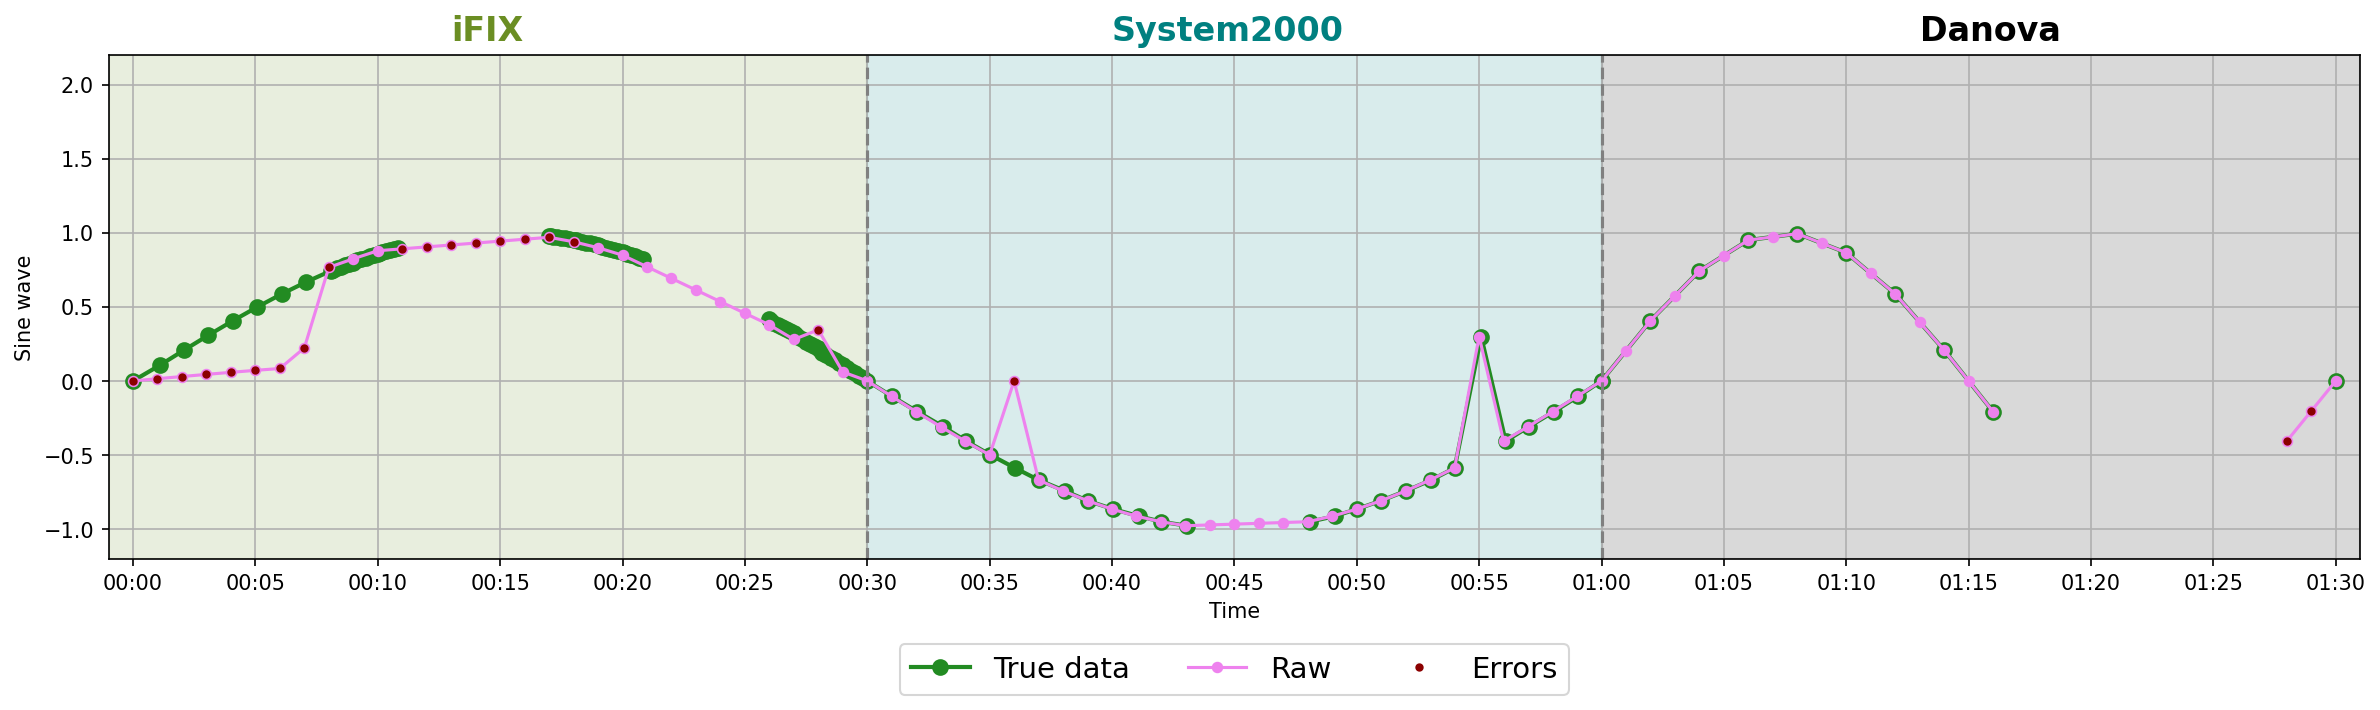

In [23]:
# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)

plt.plot(complete_data['time'], complete_data['raw_value'], 'o-', color='violet', markersize=4.5)

errors = complete_data.loc[complete_data['error']]
plt.plot(errors['time'], errors['raw_value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

plt.legend(['True data', 'Raw', 'Errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)


plt.tight_layout()
plt.savefig(figure_save_path / 'adjusted_raw.png')
plt.show()


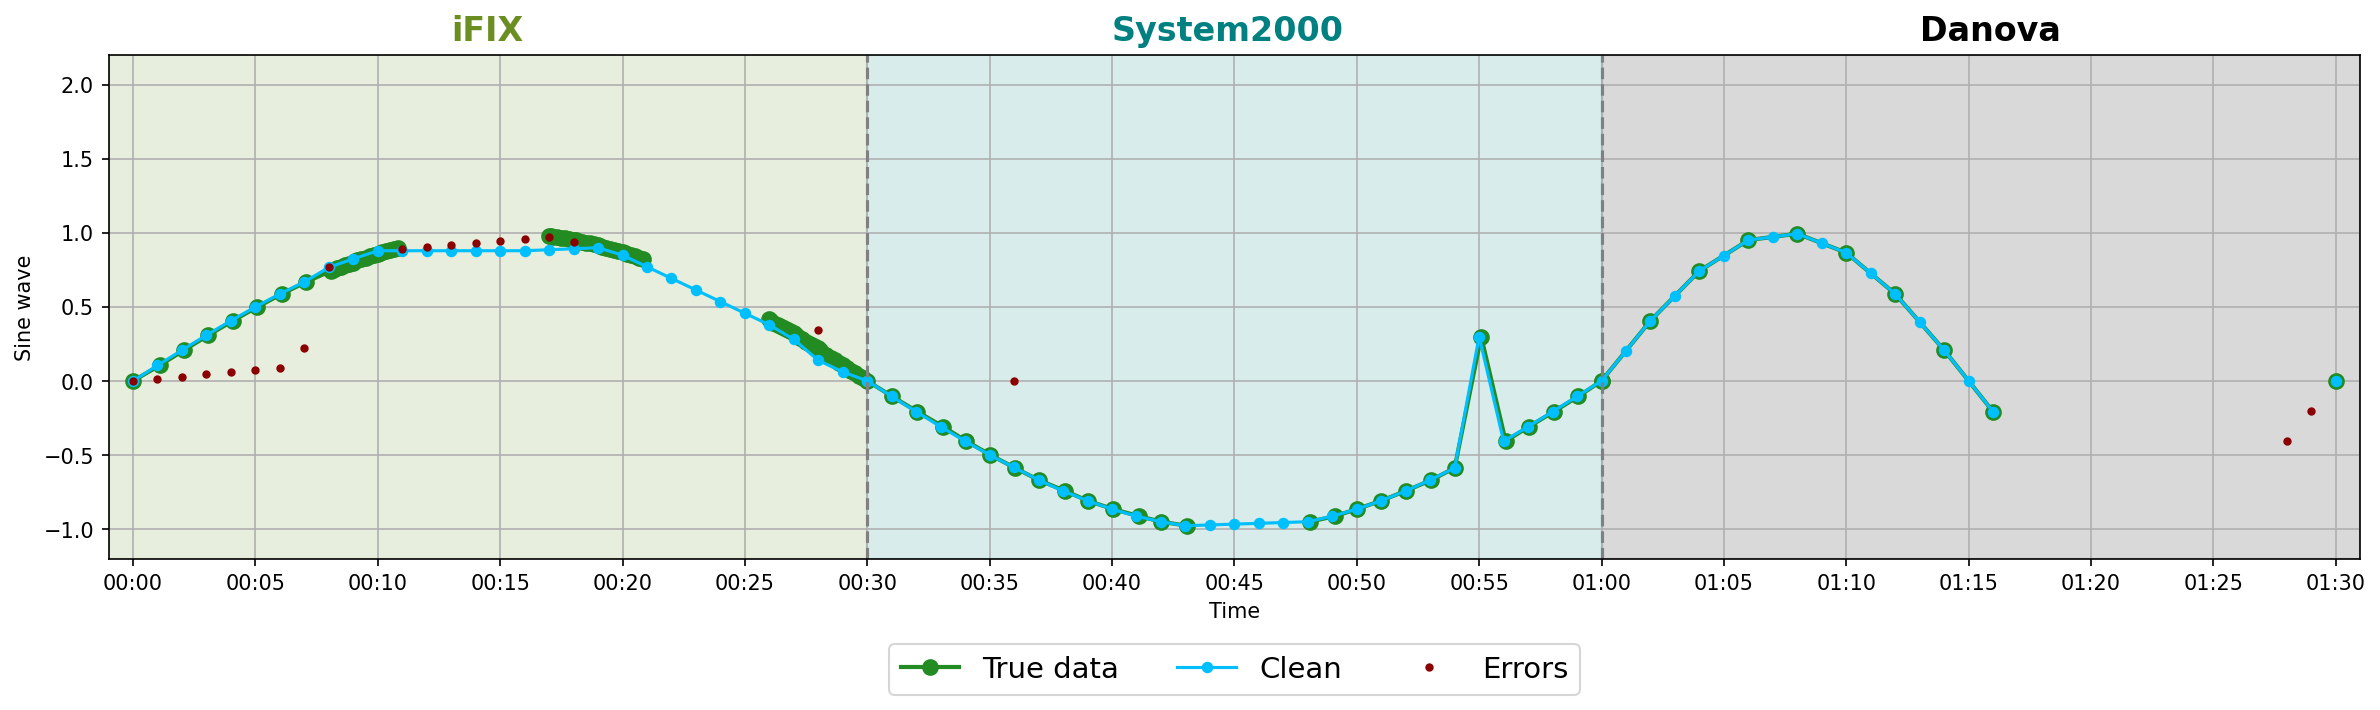

In [24]:
# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)

plt.plot(complete_data['time'], complete_data['value_no_errors'], 'o-', color='deepskyblue', markersize=4.5)

errors = complete_data.loc[complete_data['error']]
plt.plot(errors['time'], errors['raw_value'], 'o', markersize=3, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

plt.legend(['True data', 'Clean', 'Errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)


plt.tight_layout()
plt.savefig(figure_save_path / 'adjusted_clean.png')
plt.show()

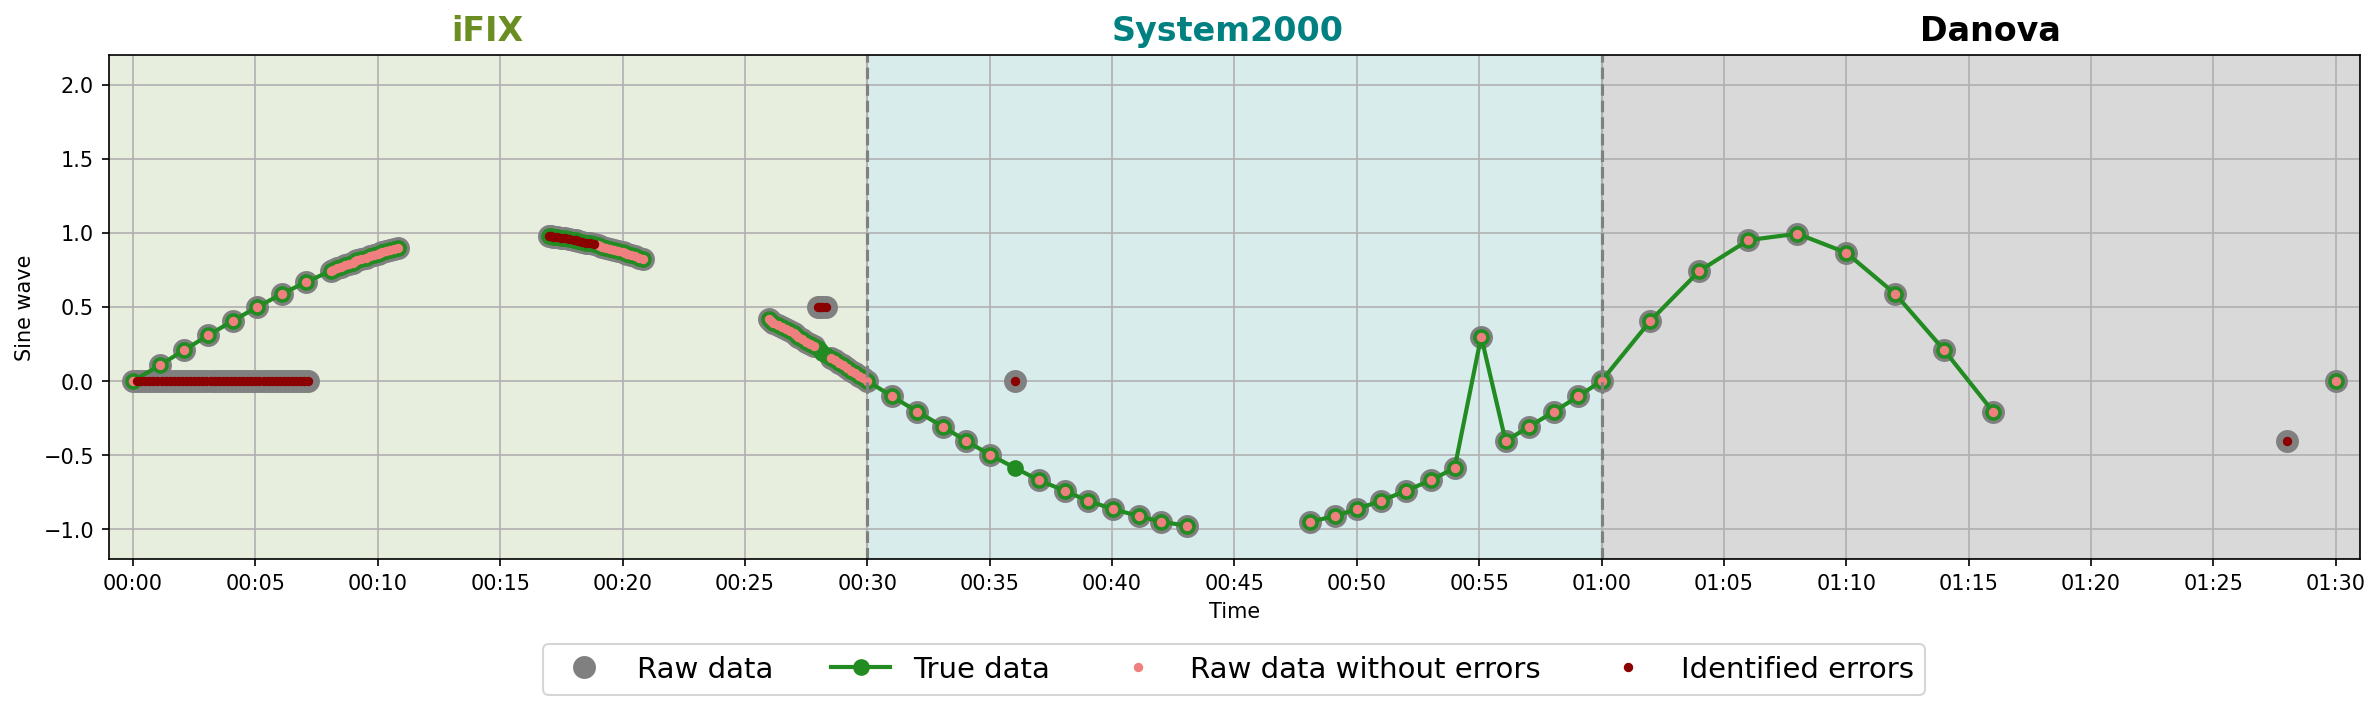

In [25]:

# visualize the data
plt.figure(figsize=(16, 5), dpi=150)
plt.plot(data['time'], data['value'], 'o', color='gray', markersize=10)
plt.plot(true_series['time'], true_series['value'], 'o-', color='forestgreen', markersize=7, linewidth=2)
plt.plot(data.time, data['value_no_errors'], 'o', color='lightcoral', markersize=3.5)
errors = data.loc[data['error']]
plt.plot(errors['time'], errors['value'], 'o', markersize=3.5, color='darkred')

default_data_plot(sep_12_index, sep_23_idx)

# add legend
plt.legend(['Raw data','True data', 'Raw data without errors', 'Identified errors'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.3), fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
# stop
raise ValueError('Stop here')

ValueError: Stop here

Checking the raw datafile

In [ ]:
import re

from fault_management_uds.data.load_data import import_metadata
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR

scripts_path = RAW_DATA_DIR / 'Bellinge' / 'scripts'
sensor_data_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'


In [ ]:
# load metadata
metadata, _ = import_metadata(scripts_path)

In [ ]:
metadata['window_frozen'].value_counts()

window_frozen
20     32
60      2
360     2
Name: count, dtype: int64

In [ ]:
ifix_metadata = metadata[metadata['Source']=='iFix']

In [ ]:

def FromDanishDSTtimeToUTC(input_t):
    # Convert Flow data to UTC
    t=input_t
    # Create index values for shift in summer/witner time
    sshift9 = datetime.datetime(2009,3,29,2,00,00)
    sshift10 = datetime.datetime(2010,3,28,2,00,00)
    sshift11 = datetime.datetime(2011,3,27,2,00,00)
    sshift12 = datetime.datetime(2012,3,25,2,00,00)
    sshift13 = datetime.datetime(2013,3,31,2,00,00)
    sshift14 = datetime.datetime(2014,3,30,2,00,00)
    sshift15 = datetime.datetime(2015,3,29,2,00,00)
    sshift16 = datetime.datetime(2016,3,27,2,00,00)
    sshift17 = datetime.datetime(2017,3,26,2,00,00)
    sshift18 = datetime.datetime(2018,3,25,2,00,00)
    sshift19 = datetime.datetime(2019,3,31,2,00,00)
    sshift20 = datetime.datetime(2020,3,29,2,00,00)
    sshift21 = datetime.datetime(2021,3,28,2,00,00)
    wshift9 = datetime.datetime(2009,10,25,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift10 = datetime.datetime(2010,10,31,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift11 = datetime.datetime(2011,10,30,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift12 = datetime.datetime(2012,10,28,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift13 = datetime.datetime(2013,10,27,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift14 = datetime.datetime(2014,10,26,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift15 = datetime.datetime(2015,10,25,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift16 = datetime.datetime(2016,10,30,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift17 = datetime.datetime(2017,10,29,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift18 = datetime.datetime(2018,10,28,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift19 = datetime.datetime(2019,10,27,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift20 = datetime.datetime(2020,10,25,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshift21 = datetime.datetime(2021,10,31,2,00,00) # 2 o'clock instead of 3 o'clock as the wintertime change the time one hour back
    wshiftindex = [wshift9, wshift10, wshift11, wshift12, wshift13, wshift14, wshift15, wshift16, wshift17, wshift18, wshift19, wshift20, wshift21]
    shiftindex9 = np.where(np.logical_and(t>=sshift9,t<wshift9))[0]
    shiftindex10 = np.where(np.logical_and(t>=sshift10,t<wshift10))[0]
    shiftindex11 = np.where(np.logical_and(t>=sshift11,t<wshift11))[0]
    shiftindex12 = np.where(np.logical_and(t>=sshift12,t<wshift12))[0]
    shiftindex13 = np.where(np.logical_and(t>=sshift13,t<wshift13))[0]
    shiftindex14 = np.where(np.logical_and(t>=sshift14,t<wshift14))[0]
    shiftindex15 = np.where(np.logical_and(t>=sshift15,t<wshift15))[0]
    shiftindex16 = np.where(np.logical_and(t>=sshift16,t<wshift16))[0]
    shiftindex17 = np.where(np.logical_and(t>=sshift17,t<wshift17))[0]
    shiftindex18 = np.where(np.logical_and(t>=sshift18,t<wshift18))[0]
    shiftindex19 = np.where(np.logical_and(t>=sshift19,t<wshift19))[0]
    shiftindex20 = np.where(np.logical_and(t>=sshift20,t<wshift20))[0]
    shiftindex21 = np.where(np.logical_and(t>=sshift21,t<wshift21))[0]
    shiftindex = [*shiftindex9, *shiftindex10, *shiftindex11, *shiftindex12, *shiftindex13, *shiftindex14,*shiftindex15,
                  *shiftindex16, *shiftindex17, *shiftindex18, *shiftindex19, *shiftindex20, *shiftindex21]
    # Convert time series to UTC
    t_UTC = t - datetime.timedelta(hours=1) # Substract one hour from all data
    t_UTC1=pd.DataFrame(t_UTC, index=range(len(t_UTC)), columns=['time'])
    t_UTC1.iloc[shiftindex,0]=t_UTC1.iloc[shiftindex,0] - pd.Timedelta(hours=1) # Substract an extra hour at summer time

  
    #Ensures that the double values in shift to wintertime is not located double. No matter what time a double value start as. 
    for i in range(0, len(wshiftindex)): 
       
        if int((wshiftindex[i]-pd.Timedelta(hours=1)) > t_UTC1.iloc[0]) & int(wshiftindex[i] < t_UTC1.iloc[-1]): #apply only for valid data
            tstart = t_UTC1.loc[t_UTC1['time']>(wshiftindex[i]-pd.Timedelta(hours=1))].iloc[[0,]].index[0]
            t_realend = t_UTC1.loc[t_UTC1['time']>(wshiftindex[i])].iloc[[0,]].index[0]
            tend = 0

            if t_realend > 0:
                for j in range(tstart, t_realend):
        
                    if t_UTC1.time[j] > t_UTC1.time[j+1]:
                        tend = j+1
                        t_UTC1.time[(tstart-1):tend]=(t_UTC1.time[(tstart-1):tend] - pd.Timedelta(hours=1))
                    else: 
                        pass
   
    
    return t_UTC1

def import_ifix(path, conversion):
    #IFIX
  
    dfI = pd.read_fwf(path, decimal=",", sep='\t', parse_dates=True, skiprows=(1), skipfooter=(3))
    dfI.columns = ['time','value','Quality'] #Nyt navn til kolonner da gamle er mærkelige

    #Convert scientific number with commas with dots
    dfI['value'] = pd.to_numeric(dfI['value'].apply(lambda x: re.sub(',', '.', str(x))))
    dfI['time'] = pd.to_datetime(dfI['time'], format="%Y-%m-%d %H:%M:%S.%f") #Gør så data bliver i rigtig dato format

    #Change time to UTC - easiest for now!
    dfI['UTCtime'] =  FromDanishDSTtimeToUTC(dfI['time'])
    
            
    raw_data = pd.DataFrame({'time': dfI['UTCtime'],
                         'value': round(dfI['value'],3), #round data
                         'quality_ifix':dfI['Quality']})
    
    raw_data['value']=raw_data['value']/conversion #convert to m

    return raw_data


In [ ]:
row = ifix_metadata.iloc[5]
file_path = sensor_data_path / row['Folderpath'] / row['Filename']
print(file_path)
row

/Users/arond.jacobsen/Documents/GitHub/fault_management_uds/data/raw/Bellinge/sensor-data/2_raw_data/SVTP03.G71F05R-D1-W1-BL2!M5-PV-SMO.F_CV.rpt


IdMeasurement                                 G71F05R_LevelInlet
Area                                                    Bellinge
Source                                                      iFix
Version                                                       p1
Type                                                       Level
Folderpath                                         ./2_raw_data/
Filename             SVTP03.G71F05R-D1-W1-BL2!M5-PV-SMO.F_CV.rpt
TagSRO                   SVTP03.G71F05R-D1-W1-BL2!M5-PV-SMO.F_CV
Navn                                                 Niv. Indløb
StartTime                                    2020-10-13 00:00:00
EndTime                                      2021-08-19 00:00:00
Conversion                                                   1.0
comment                                                      NaN
unit                                                          cm
obvious_min                                                0.001
obvious_max              

In [ ]:
raw_data = import_ifix(file_path, row['Conversion'])

In [ ]:
raw_data.iloc[100020:100040]

,time,value,quality_ifix
100020,2020-10-16 20:03:00,0.256,100
100021,2020-10-16 20:03:10,0.256,100
100022,2020-10-16 20:03:20,0.256,100
100023,2020-10-16 20:03:30,0.256,100
100024,2020-10-16 20:03:40,0.256,100
100025,2020-10-16 20:03:50,0.256,100
100026,2020-10-16 20:04:00,0.256,100
100027,2020-10-16 20:04:10,0.256,100
100028,2020-10-16 20:04:20,0.256,100
100029,2020-10-16 20:04:30,0.256,100


- the stamped datapoint seem to be 0 and sampled on a 10 second basis